In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle as pkl
from numpy import sort
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

In [44]:
#link - https://www.kaggle.com/vtrulyaev/ndcg-scorer
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer


def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    # get first array element of predictions array to correct calculate ground_truth len
    lb.fit(range(len(predictions[0]) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        
        # HACK: Should not be needed, but in case nothing was relevant
        if best <= 0:
            score = 0.0
        else:
            score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [22]:
train_df = pd.read_csv('X_train2.csv')

In [23]:
train_df.fillna(0,inplace=True)

In [24]:
# taking a dummy variable to perform the calculation on
X = pd.read_csv('X_train2.csv')

In [25]:
with open('labels.pkl','rb') as f:
    Y = pkl.load(f)
    print(Y.shape)

(73812,)


In [26]:
train_df.head()

,id,age,year,month,day,tfa_year,tfa_month,tfa_day,timediff,gender_-unknown-,...,view_resolutions,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips
0,d1mm9tcy42,62.0,2014,1,1,2014,1,1,0,0,...,0.0,23.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0
1,yo8nz8bqcq,-1.0,2014,1,1,2014,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4grx6yxeby,-1.0,2014,1,1,2014,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,ncf87guaf0,-1.0,2014,1,1,2014,1,1,0,1,...,0.0,32.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
4,4rvqpxoh3h,-1.0,2014,1,1,2014,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train_df.shape

(73812, 321)

In [28]:
train_df.set_index('id',inplace=True)

In [29]:
X.set_index('id',inplace=True)

In [30]:
X.fillna(0,inplace=True)

## Train set with only important features

In [31]:
#using random forest to select the indices of important features 
def imp_features(data,keep_num_features):
    clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
    clf.fit(data,Y)
    important_features_index = np.argsort(clf.feature_importances_)[::-1]
    imp_index_filtered = important_features_index[:keep_num_features]
    return imp_index_filtered

In [32]:
important_indexes = imp_features(X,160)

In [33]:
type(important_indexes)

numpy.ndarray

In [41]:
important_indexes

array([  0, 164, 163,   3,   6, 162, 165, 311, 250, 256, 239, 315,   2,
         5, 190, 281,   8, 254, 205, 203, 291, 298, 219, 197, 319, 196,
       233, 240,   9, 262, 161, 211,  10, 114,  13,  96, 299, 100,  12,
       103, 183, 303,  90, 187, 249, 204, 149,  93, 123,  62,  72,  65,
       294,  76, 301, 179, 266, 231, 317, 128, 136, 290, 104, 166, 279,
        66, 297, 246, 248, 237, 232, 251, 247, 201,  67, 300, 273, 228,
        40, 293, 271, 264, 269, 105, 175, 255, 106, 292, 314,  16, 235,
       242, 241,  61, 278,  88, 238, 234, 180,  95,  89,  74,  33, 210,
       283, 280,  98,  69, 236,  80,  94,  32,  87,  64, 101, 287,  59,
       230, 229,  99, 168, 289,  97, 115,  25,  63, 302, 267, 261, 227,
        43, 217, 185,  86,  50,  60,  31,  41, 170, 169, 275, 215, 258,
        38, 307, 270, 216,  23, 221, 198, 108,  81, 276, 188, 213,  55,
       288, 284,  48,  11], dtype=int64)

In [43]:
with open('important_indices.pkl','wb') as f:
    pkl.dump(important_indexes,f)

In [44]:
with open('important_indices.pkl','wb') as f:
    pkl.dump(important_indexes,f)

In [45]:
important_indexes

array([  0, 164, 163,   3,   6, 162, 165, 311, 250, 256, 239, 315,   2,
         5, 190, 281,   8, 254, 205, 203, 291, 298, 219, 197, 319, 196,
       233, 240,   9, 262, 161, 211,  10, 114,  13,  96, 299, 100,  12,
       103, 183, 303,  90, 187, 249, 204, 149,  93, 123,  62,  72,  65,
       294,  76, 301, 179, 266, 231, 317, 128, 136, 290, 104, 166, 279,
        66, 297, 246, 248, 237, 232, 251, 247, 201,  67, 300, 273, 228,
        40, 293, 271, 264, 269, 105, 175, 255, 106, 292, 314,  16, 235,
       242, 241,  61, 278,  88, 238, 234, 180,  95,  89,  74,  33, 210,
       283, 280,  98,  69, 236,  80,  94,  32,  87,  64, 101, 287,  59,
       230, 229,  99, 168, 289,  97, 115,  25,  63, 302, 267, 261, 227,
        43, 217, 185,  86,  50,  60,  31,  41, 170, 169, 275, 215, 258,
        38, 307, 270, 216,  23, 221, 198, 108,  81, 276, 188, 213,  55,
       288, 284,  48,  11], dtype=int64)

In [39]:
col_names = X.columns

In [40]:
col_names1 =col_names.to_list()

In [42]:
col_names

['age',
 'year',
 'month',
 'day',
 'tfa_year',
 'tfa_month',
 'tfa_day',
 'timediff',
 'gender_-unknown-',
 'gender_FEMALE',
 'gender_MALE',
 'gender_OTHER',
 'signup_method_basic',
 'signup_method_facebook',
 'signup_method_google',
 'signup_method_weibo',
 'signup_flow_0',
 'signup_flow_1',
 'signup_flow_2',
 'signup_flow_3',
 'signup_flow_4',
 'signup_flow_5',
 'signup_flow_6',
 'signup_flow_8',
 'signup_flow_10',
 'signup_flow_12',
 'signup_flow_14',
 'signup_flow_15',
 'signup_flow_16',
 'signup_flow_20',
 'signup_flow_21',
 'signup_flow_23',
 'signup_flow_24',
 'signup_flow_25',
 'language_-unknown-',
 'language_ca',
 'language_cs',
 'language_da',
 'language_de',
 'language_el',
 'language_en',
 'language_es',
 'language_fi',
 'language_fr',
 'language_hr',
 'language_hu',
 'language_id',
 'language_is',
 'language_it',
 'language_ja',
 'language_ko',
 'language_nl',
 'language_no',
 'language_pl',
 'language_pt',
 'language_ru',
 'language_sv',
 'language_th',
 'language_tr',


In [36]:
#droping the columns whose indices aren't in the important list
for col in train_df.columns:
    if col not in np.take(col_names,important_indexes):
        train_df.drop(col,axis=1,inplace=True)

In [37]:
train_df.head()

,age,month,day,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,...,user_reviews,user_social_connections,user_tax_forms,user_wishlists,view_listing,view_search_results,wishlist,wishlist_content_update,your_listings,your_trips
id,,,,,,,,,,,,,,,,,,,,,
d1mm9tcy42,62.0,1,1,1,1,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,23.0,0.0,25.0,0.0,0.0
yo8nz8bqcq,-1.0,1,1,1,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4grx6yxeby,-1.0,1,1,1,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ncf87guaf0,-1.0,1,1,1,1,1,0,0,0,1,...,0.0,0.0,0.0,2.0,0.0,32.0,0.0,10.0,0.0,0.0
4rvqpxoh3h,-1.0,1,1,1,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
train_df.to_csv("imp_Xtrain.csv")

In [46]:
test_df = pd.read_csv('X_test2.csv')

In [47]:
test_df.set_index('id',inplace=True)

In [48]:
test_df.fillna(0,inplace=True)

### Test set with only the important features

In [49]:
#droping the columns whose indices aren't in the important indices list
for col in test_df.columns:
    if col not in np.take(col_names,important_indexes):
        test_df.drop(col,axis=1,inplace=True)

In [50]:
test_df.head()

,age,month,day,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,...,user_reviews,user_social_connections,user_tax_forms,user_wishlists,view_listing,view_search_results,wishlist,wishlist_content_update,your_listings,your_trips
id,,,,,,,,,,,,,,,,,,,,,
5uwns89zht,35.0,7,1,7,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
jtl0dijy2j,-1.0,7,1,7,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
xx0ulgorjt,-1.0,7,1,7,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,48.0,0.0,6.0,0.0,0.0
6c6puo6ix0,-1.0,7,1,7,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0
czqhjk3yfe,-1.0,7,1,7,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [51]:
test_df.to_csv('imp_Xtest.csv')

In [54]:
train_df = pd.read_csv('imp_Xtrain.csv')

In [55]:
train_df.head()

,id,age,month,day,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,...,user_reviews,user_social_connections,user_tax_forms,user_wishlists,view_listing,view_search_results,wishlist,wishlist_content_update,your_listings,your_trips
0,d1mm9tcy42,62.0,1,1,1,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,23.0,0.0,25.0,0.0,0.0
1,yo8nz8bqcq,-1.0,1,1,1,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4grx6yxeby,-1.0,1,1,1,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,ncf87guaf0,-1.0,1,1,1,1,1,0,0,0,...,0.0,0.0,0.0,2.0,0.0,32.0,0.0,10.0,0.0,0.0
4,4rvqpxoh3h,-1.0,1,1,1,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
test_df = pd.read_csv('imp_Xtest.csv')

In [57]:
test_df.head()

,id,age,month,day,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,...,user_reviews,user_social_connections,user_tax_forms,user_wishlists,view_listing,view_search_results,wishlist,wishlist_content_update,your_listings,your_trips
0,5uwns89zht,35.0,7,1,7,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
1,jtl0dijy2j,-1.0,7,1,7,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
2,xx0ulgorjt,-1.0,7,1,7,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,48.0,0.0,6.0,0.0,0.0
3,6c6puo6ix0,-1.0,7,1,7,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0
4,czqhjk3yfe,-1.0,7,1,7,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [58]:
test_df.fillna(0,inplace=True)

In [59]:
test_df.set_index('id',inplace=True)

In [60]:
test_df.head()

,age,month,day,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,...,user_reviews,user_social_connections,user_tax_forms,user_wishlists,view_listing,view_search_results,wishlist,wishlist_content_update,your_listings,your_trips
id,,,,,,,,,,,,,,,,,,,,,
5uwns89zht,35.0,7,1,7,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
jtl0dijy2j,-1.0,7,1,7,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
xx0ulgorjt,-1.0,7,1,7,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,48.0,0.0,6.0,0.0,0.0
6c6puo6ix0,-1.0,7,1,7,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0
czqhjk3yfe,-1.0,7,1,7,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [61]:
train_df.set_index('id',inplace=True)

In [62]:
train_df.fillna(0,inplace=True)

In [63]:
train_df.head()

,age,month,day,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,...,user_reviews,user_social_connections,user_tax_forms,user_wishlists,view_listing,view_search_results,wishlist,wishlist_content_update,your_listings,your_trips
id,,,,,,,,,,,,,,,,,,,,,
d1mm9tcy42,62.0,1,1,1,1,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,23.0,0.0,25.0,0.0,0.0
yo8nz8bqcq,-1.0,1,1,1,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4grx6yxeby,-1.0,1,1,1,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ncf87guaf0,-1.0,1,1,1,1,1,0,0,0,1,...,0.0,0.0,0.0,2.0,0.0,32.0,0.0,10.0,0.0,0.0
4rvqpxoh3h,-1.0,1,1,1,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
train_df.shape

(73812, 160)

## Xgboost Classifier

In [12]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.2,0.25],
     'n_estimators':[50,100,200,500,1000],
     'max_depth':[3,6,5,10],
    'colsample_bytree':[0.1,0.3,0.5,0.7],
    'subsample':[0.1,0.3,0.5,0.8]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,cv= 3,verbose=10,n_jobs=-1,)
random_cfl.fit(train_df,Y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 54.8min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 61.2min finished


RandomizedSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.3, 0.5,
                                                             0.7],
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.2, 0.25],
                                        'max_depth': [3, 6, 5, 10],
                                        'n_estimators': [50, 100, 200, 500,
                                                         1000],
                                        'subsample': [0.1, 0.3, 0.5, 0.8]},
                   verbose=10)

In [13]:
random_cfl.best_params_

{'subsample': 0.1,
 'n_estimators': 500,
 'max_depth': 3,
 'learning_rate': 0.03,
 'colsample_bytree': 0.3}

In [14]:
x_cfl=XGBClassifier(n_estimators=500,max_depth=3,learning_rate=0.03,colsample_bytree=0.3,subsample=0.1,nthread=-1)
x_cfl.fit(train_df,Y,verbose=True)


XGBClassifier(colsample_bytree=0.3, learning_rate=0.03, n_estimators=500,
              nthread=-1, objective='multi:softprob', subsample=0.1)

In [15]:
import pickle 
pickle.dump(x_cfl,open('impxgboost.pickle.dat','wb'))

In [45]:
classifier = pickle.load(open('impxgboost.pickle.dat','rb'))

In [18]:
test_df.set_index('id',inplace=True)

In [19]:
test_df.head()

,age,month,day,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,signup_method_basic,signup_method_facebook,...,user_social_connections,user_tax_forms,user_wishlists,view_listing,view_search_results,wishlist,wishlist_content_update,your_listings,your_reservations,your_trips
id,,,,,,,,,,,,,,,,,,,,,
5uwns89zht,35.0,7,1,7,1,0,1,0,0,1,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
jtl0dijy2j,-1.0,7,1,7,1,1,0,0,1,0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
xx0ulgorjt,-1.0,7,1,7,1,1,0,0,1,0,...,0.0,0.0,0.0,0.0,48.0,0.0,6.0,0.0,0.0,0.0
6c6puo6ix0,-1.0,7,1,7,1,1,0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0
czqhjk3yfe,-1.0,7,1,7,1,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [46]:
pred_probab = classifier.predict_proba(test_df)

In [21]:
pred_probab_df = pd.DataFrame(pred_probab,index=test_df.index)

In [22]:
pred_probab_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
id,,,,,,,,,,,,
5uwns89zht,0.001348,0.003388,0.001354,0.006484,0.009293,0.005759,0.004955,0.736903,0.001359,0.000528,0.195337,0.033291
jtl0dijy2j,0.000643,0.002042,0.000653,0.003399,0.005007,0.002858,0.004524,0.918438,0.000989,0.000597,0.048634,0.012215
xx0ulgorjt,0.000558,0.003694,0.000904,0.003437,0.007690,0.003184,0.005945,0.902449,0.000925,0.000987,0.052349,0.017878
6c6puo6ix0,0.000633,0.002954,0.000787,0.005300,0.007852,0.002682,0.005044,0.901289,0.001160,0.000814,0.054346,0.017140
czqhjk3yfe,0.002832,0.024966,0.004055,0.018896,0.057158,0.026750,0.038000,0.180890,0.007104,0.009848,0.520572,0.108928


In [23]:
output_classes = {'AU': 0,
 'CA': 1,
 'DE': 2,
 'ES': 3,
 'FR': 4,
 'GB': 5,
 'IT': 6,
 'NDF': 7,
 'NL': 8,
 'PT': 9,
 'US': 10,
 'other': 11}

In [24]:
inv_classes = {v:k for k,v in output_classes.items()}

In [25]:
def top_5_countries(s):
    """
    This function takes the probability values of each id, sorts the top 5 values and using an inverse dictionary(inv_classes) gives the top 5 countries prediction.
    """
    indices = np.arange(0,12)
    pred_dict = dict(zip(indices,s))
    sorted_abc = sorted(pred_dict.items(),key=lambda x:x[1],reverse=True)[:5]
    row_indices = [x[0] for x in sorted_abc]
    top_five = [inv_classes[i] for i in row_indices]
    return top_five

In [26]:
pred_probab_df['top_five'] = pred_probab_df.apply(top_5_countries,axis=1)

In [27]:
pred_probab_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,top_five
id,,,,,,,,,,,,,
5uwns89zht,0.001348,0.003388,0.001354,0.006484,0.009293,0.005759,0.004955,0.736903,0.001359,0.000528,0.195337,0.033291,"[NDF, US, other, FR, ES]"
jtl0dijy2j,0.000643,0.002042,0.000653,0.003399,0.005007,0.002858,0.004524,0.918438,0.000989,0.000597,0.048634,0.012215,"[NDF, US, other, FR, IT]"
xx0ulgorjt,0.000558,0.003694,0.000904,0.003437,0.007690,0.003184,0.005945,0.902449,0.000925,0.000987,0.052349,0.017878,"[NDF, US, other, FR, IT]"
6c6puo6ix0,0.000633,0.002954,0.000787,0.005300,0.007852,0.002682,0.005044,0.901289,0.001160,0.000814,0.054346,0.017140,"[NDF, US, other, FR, ES]"
czqhjk3yfe,0.002832,0.024966,0.004055,0.018896,0.057158,0.026750,0.038000,0.180890,0.007104,0.009848,0.520572,0.108928,"[US, NDF, other, FR, IT]"


In [28]:
s = pred_probab_df.apply(lambda x: pd.Series(x['top_five']),axis=1).stack().reset_index(level=1,drop=True)
s.name = 'country'

In [29]:
submission = pred_probab_df.drop([i for i in range(0,12)] + ['top_five'],axis=1).join(s)
submission.head()

,country
id,
0010k6l0om,NDF
0010k6l0om,US
0010k6l0om,other
0010k6l0om,FR
0010k6l0om,ES


In [30]:
submission.to_csv('impxgbsubmission.csv')

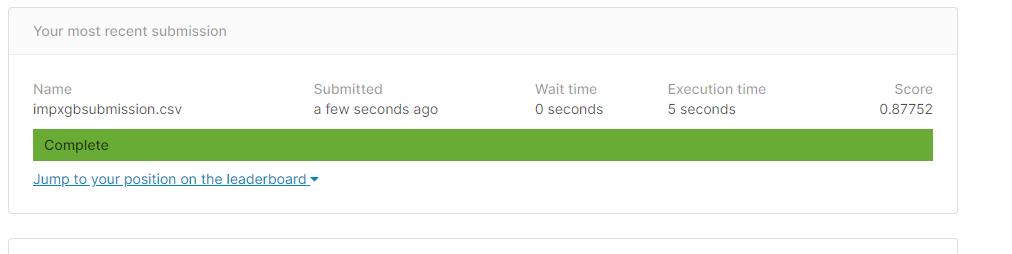

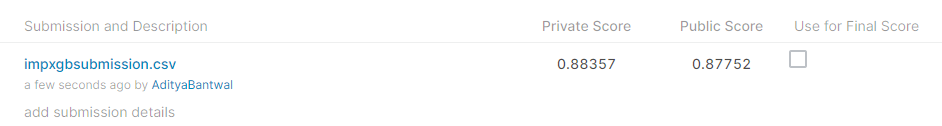

## Random Forest

In [33]:
x_cfl= RandomForestClassifier()

prams={
     'min_samples_split':[2,20],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,cv= 3,verbose=10,n_jobs=-1)
random_cfl.fit(train_df,Y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.6min remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10],
                                        'min_samples_split': [2, 20],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         2000]},
                   verbose=10)

In [34]:
random_cfl.best_params_

{'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 10}

In [35]:
#Using the best parameters to train the model
x_cfl=RandomForestClassifier(n_estimators=500,min_samples_split=2,max_depth=10)
x_cfl.fit(train_df,Y)


RandomForestClassifier(max_depth=10, n_estimators=500)

In [12]:
import pickle 
# pickle.dump(x_cfl,open('impRF.pickle.dat','wb'))

In [35]:
classifier = pickle.load(open('impRF.pickle.dat','rb'))

In [36]:
pred_probab = classifier.predict_proba(test_df)

In [43]:
ndcg_score(Y,pred_probab)

0.7997192751815778

In [40]:
# storing the predictions of each user_id in a dataframe with user_id as the index
pred_probab_df = pd.DataFrame(pred_probab,index=test_df.index)

In [41]:
pred_probab_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
id,,,,,,,,,,,,
5uwns89zht,0.001591,0.003624,0.002313,0.006600,0.012448,0.006342,0.007307,0.714988,0.002278,0.000745,0.209449,0.032316
jtl0dijy2j,0.000664,0.001860,0.000946,0.003721,0.007824,0.003196,0.004988,0.874647,0.001018,0.000466,0.082841,0.017829
xx0ulgorjt,0.000768,0.002631,0.001045,0.004568,0.009756,0.004282,0.006852,0.854332,0.001238,0.000638,0.093184,0.020706
6c6puo6ix0,0.000703,0.002589,0.001032,0.004657,0.010227,0.004203,0.007036,0.855365,0.001236,0.000613,0.091546,0.020794
czqhjk3yfe,0.001767,0.014381,0.004084,0.018438,0.047249,0.019202,0.039174,0.188846,0.008225,0.007726,0.547257,0.103653


In [42]:
pred_probab_df['top_five'] = pred_probab_df.apply(top_5_countries,axis=1)

In [43]:
pred_probab_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,top_five
id,,,,,,,,,,,,,
5uwns89zht,0.001591,0.003624,0.002313,0.006600,0.012448,0.006342,0.007307,0.714988,0.002278,0.000745,0.209449,0.032316,"[NDF, US, other, FR, IT]"
jtl0dijy2j,0.000664,0.001860,0.000946,0.003721,0.007824,0.003196,0.004988,0.874647,0.001018,0.000466,0.082841,0.017829,"[NDF, US, other, FR, IT]"
xx0ulgorjt,0.000768,0.002631,0.001045,0.004568,0.009756,0.004282,0.006852,0.854332,0.001238,0.000638,0.093184,0.020706,"[NDF, US, other, FR, IT]"
6c6puo6ix0,0.000703,0.002589,0.001032,0.004657,0.010227,0.004203,0.007036,0.855365,0.001236,0.000613,0.091546,0.020794,"[NDF, US, other, FR, IT]"
czqhjk3yfe,0.001767,0.014381,0.004084,0.018438,0.047249,0.019202,0.039174,0.188846,0.008225,0.007726,0.547257,0.103653,"[US, NDF, other, FR, IT]"


In [44]:
# ungrouping the list values of the top_five column
s = pred_probab_df.apply(lambda x: pd.Series(x['top_five']),axis=1).stack().reset_index(level=1,drop=True)
s.name = 'country'

In [45]:
submission = pred_probab_df.drop([i for i in range(0,12)] + ['top_five'],axis=1).join(s)
submission.head()

,country
id,
0010k6l0om,NDF
0010k6l0om,US
0010k6l0om,other
0010k6l0om,FR
0010k6l0om,IT


In [47]:
submission.to_csv('impRFsubmission.csv')

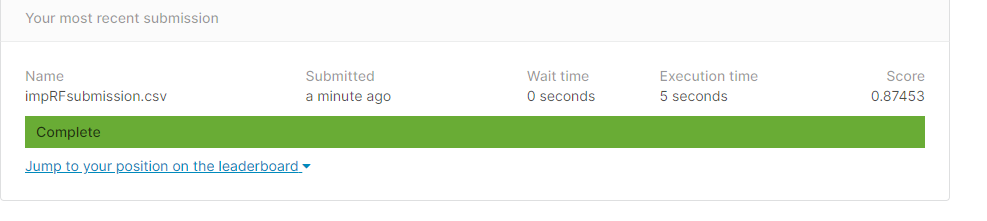

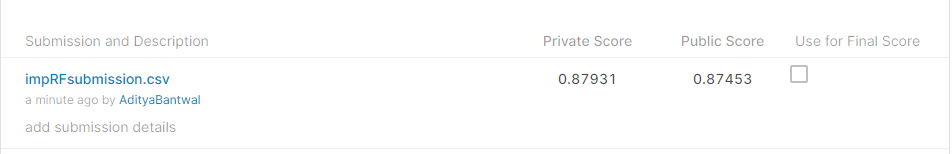

In [65]:
# splitting the train data into train and Cross validation data
from sklearn.model_selection import train_test_split
X_train,X_cv,y_train,y_cv = train_test_split(train_df,Y,test_size=0.20)

## Stacking Classifier

In [66]:
#class sklearn.ensemble.StackingClassifier(estimators, final_estimator=None, *, cv=None, stack_method='auto', n_jobs=None, passthrough=False, verbose=0)
# link - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
alpha = [0.0001,0.001,0.01,0.1,1,10] 
estimators = [('xgb',XGBClassifier(n_estimators=500,max_depth=3,learning_rate=0.03,colsample_bytree=0.3,subsample=0.1,nthread=-1)),
               ('rf',RandomForestClassifier(n_estimators=500,min_samples_split=2,max_depth=10))]
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(estimators=estimators, final_estimator=lr)
    sclf.fit(X_train,y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_cv, sclf.predict_proba(X_cv))))
    log_error =log_loss(y_cv, sclf.predict_proba(X_cv))
    if best_alpha > log_error:
        best_alpha = log_error

Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.045
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 0.961
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 0.945


C:\Users\user\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 0.941


C:\Users\user\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 0.938


C:\Users\user\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 0.937


In [67]:
estimators = [('xgb',XGBClassifier(n_estimators=500,max_depth=3,learning_rate=0.03,colsample_bytree=0.3,subsample=0.1,nthread=-1)),
               ('rf',RandomForestClassifier(n_estimators=500,min_samples_split=2,max_depth=10))]
lr = LogisticRegression(C=10.000000)
sclf = StackingClassifier(estimators=estimators, final_estimator=lr)
sclf.fit(X_train,y_train)

C:\Users\user\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(colsample_bytree=0.3,
                                              learning_rate=0.03,
                                              n_estimators=500, nthread=-1,
                                              subsample=0.1)),
                               ('rf',
                                RandomForestClassifier(max_depth=10,
                                                       n_estimators=500))],
                   final_estimator=LogisticRegression(C=10.0))

In [68]:
import pickle 
pickle.dump(sclf,open('stackingclf1.pickle.dat','wb'))

In [69]:
classifier = pickle.load(open('stackingclf1.pickle.dat','rb'))

In [26]:
test_df.head()

,id,age,month,day,tfa_month,tfa_day,gender_-unknown-,gender_FEMALE,gender_MALE,signup_method_basic,...,user_social_connections,user_tax_forms,user_wishlists,view_listing,view_search_results,wishlist,wishlist_content_update,your_listings,your_reservations,your_trips
0,5uwns89zht,35.0,7,1,7,1,0,1,0,0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1,jtl0dijy2j,-1.0,7,1,7,1,1,0,0,1,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2,xx0ulgorjt,-1.0,7,1,7,1,1,0,0,1,...,0.0,0.0,0.0,0.0,48.0,0.0,6.0,0.0,0.0,0.0
3,6c6puo6ix0,-1.0,7,1,7,1,1,0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0
4,czqhjk3yfe,-1.0,7,1,7,1,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
test_df.set_index('id',inplace=True)

In [49]:
# since in the problem statement it is mentioned that the we need to predict the top 5 destinations so we need to predict the probabilistic value of the test data
pred_probab = classifier.predict_proba(test_df)

In [50]:
ndcg_score(Y,pred_probab)

0.788580110904222

In [30]:
# storing the predictions of each user_id in a dataframe with user_id as the index
pred_probab_df = pd.DataFrame(pred_probab,index=test_df.index)

In [31]:
pred_probab_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
id,,,,,,,,,,,,
5uwns89zht,0.001139,0.003217,0.001732,0.005167,0.010172,0.005415,0.007185,0.778874,0.001810,0.000673,0.154222,0.030394
jtl0dijy2j,0.000551,0.001486,0.000813,0.002568,0.005085,0.002635,0.003777,0.903564,0.000850,0.000340,0.063323,0.015009
xx0ulgorjt,0.000621,0.001683,0.000924,0.002939,0.005923,0.002993,0.004398,0.893672,0.000969,0.000386,0.068657,0.016835
6c6puo6ix0,0.000626,0.001701,0.000932,0.002966,0.005998,0.003026,0.004446,0.892665,0.000982,0.000389,0.069160,0.017109
czqhjk3yfe,0.005169,0.016121,0.008965,0.025866,0.059067,0.025625,0.039220,0.130506,0.009451,0.003121,0.566347,0.110542


In [32]:
# The dictionary is the label encoding of the countries feature
output_classes = {'AU': 0,
 'CA': 1,
 'DE': 2,
 'ES': 3,
 'FR': 4,
 'GB': 5,
 'IT': 6,
 'NDF': 7,
 'NL': 8,
 'PT': 9,
 'US': 10,
 'other': 11}

In [33]:
# inverting the dictionary
inv_classes = {v:k for k,v in output_classes.items()}

In [34]:
inv_classes

{0: 'AU',
 1: 'CA',
 2: 'DE',
 3: 'ES',
 4: 'FR',
 5: 'GB',
 6: 'IT',
 7: 'NDF',
 8: 'NL',
 9: 'PT',
 10: 'US',
 11: 'other'}

In [35]:
def top_5_countries(s):
    """
    This function takes the probability values of each id, sorts the top 5 values and using an inverse dictionary(inv_classes) gives the top 5 countries prediction.
    """
    indices = np.arange(0,12)
    pred_dict = dict(zip(indices,s))
    sorted_abc = sorted(pred_dict.items(),key=lambda x:x[1],reverse=True)[:5]
    row_indices = [x[0] for x in sorted_abc]
    top_five = [inv_classes[i] for i in row_indices]
    return top_five

In [36]:
# here we apply the above function on each row of the dataframe to get the top 5 prediction.
pred_probab_df['top_five'] = pred_probab_df.apply(top_5_countries,axis=1)

In [37]:
pred_probab_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,top_five
id,,,,,,,,,,,,,
5uwns89zht,0.001139,0.003217,0.001732,0.005167,0.010172,0.005415,0.007185,0.778874,0.001810,0.000673,0.154222,0.030394,"[NDF, US, other, FR, IT]"
jtl0dijy2j,0.000551,0.001486,0.000813,0.002568,0.005085,0.002635,0.003777,0.903564,0.000850,0.000340,0.063323,0.015009,"[NDF, US, other, FR, IT]"
xx0ulgorjt,0.000621,0.001683,0.000924,0.002939,0.005923,0.002993,0.004398,0.893672,0.000969,0.000386,0.068657,0.016835,"[NDF, US, other, FR, IT]"
6c6puo6ix0,0.000626,0.001701,0.000932,0.002966,0.005998,0.003026,0.004446,0.892665,0.000982,0.000389,0.069160,0.017109,"[NDF, US, other, FR, IT]"
czqhjk3yfe,0.005169,0.016121,0.008965,0.025866,0.059067,0.025625,0.039220,0.130506,0.009451,0.003121,0.566347,0.110542,"[US, NDF, other, FR, IT]"


In [38]:
# ungrouping the list values of the top_five column
s = pred_probab_df.apply(lambda x: pd.Series(x['top_five']),axis=1).stack().reset_index(level=1,drop=True)
s.name = 'country'

In [39]:
submission = pred_probab_df.drop([i for i in range(0,12)] + ['top_five'],axis=1).join(s)
submission.head()

,country
id,
0010k6l0om,NDF
0010k6l0om,US
0010k6l0om,other
0010k6l0om,FR
0010k6l0om,IT


In [40]:
submission.to_csv('stackingclfsubmission1.csv')

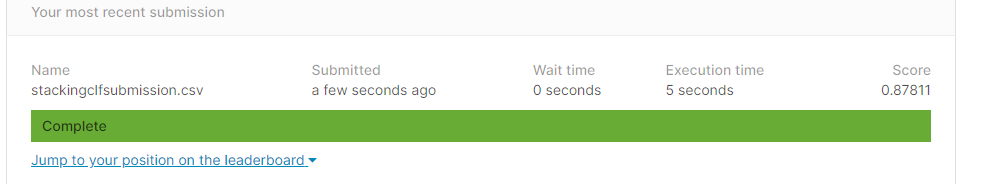

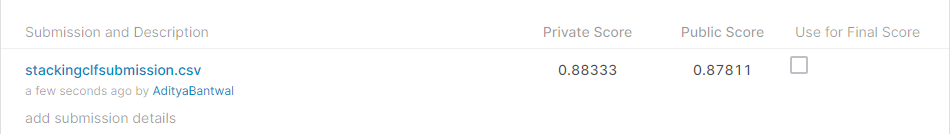

In [1]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model',"NDCG"]
x.add_row(['XGboost',' 0.87347'])
x.add_row(['Random Forest','0.87304'])
x.add_row(['XGBoost impfeatures','0.87752'])
x.add_row(['Random Forest impfeatures','0.87453'])
x.add_row(['Stacking Classifier impfeatures','0.87811'])
print(x)

ModuleNotFoundError: No module named 'prettytable'